<a href="https://colab.research.google.com/github/huongtravo0910/tabular_transformer_predict_wine_quality_score/blob/main/PredictWineQualityScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

In [13]:
# --------------------------
# Custom Dataset for Tabular Data (Used for Inference)
# --------------------------
class TabularDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels) if labels is not None else None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        return self.features[idx]


In [3]:
# --------------------------
# TabTransformer Model
# --------------------------
class TabTransformer(nn.Module):
    def __init__(self, num_features, num_classes, dim_embedding=64, num_heads=4, num_layers=4):
        super(TabTransformer, self).__init__()
        self.embedding = nn.Linear(num_features, dim_embedding)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(dim_embedding, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Adds sequence length dimension
        x = self.transformer(x)
        x = torch.mean(x, dim=1)  # Mean pooling
        return self.classifier(x)


In [4]:
# --------------------------
# Train Step Function
# --------------------------
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, correct, total_samples = 0.0, 0, 0

    for batch_features, batch_labels in dataloader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        output = model(batch_features)
        loss = loss_fn(output, batch_labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_features.size(0)
        _, predicted = torch.max(output, 1)
        correct += (predicted == batch_labels).sum().item()
        total_samples += batch_features.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    return avg_loss, accuracy


In [5]:
# --------------------------
# Test Step Function
# --------------------------
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, correct, total_samples = 0.0, 0, 0

    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            output = model(batch_features)
            loss = loss_fn(output, batch_labels)

            total_loss += loss.item() * batch_features.size(0)
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_labels).sum().item()
            total_samples += batch_features.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    return avg_loss, accuracy


In [6]:
# --------------------------
# Training Loop with Visualization
# --------------------------
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        # Save results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [7]:
# --------------------------
# Visualization Function
# --------------------------
def plot_results(results):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(results["train_loss"], label='Train Loss')
    plt.plot(results["test_loss"], label='Test Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(results["train_acc"], label='Train Accuracy')
    plt.plot(results["test_acc"], label='Test Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
# --------------------------
# Data Preparation
# --------------------------
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# Feature Engineering
X = data.drop('quality', axis=1).values
y = data['quality'].values - 3  # Zero-indexed labels

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Create DataLoaders
batch_size = 32
train_dataset = TabularDataset(X_train_scaled, y_train)
val_dataset = TabularDataset(X_val_scaled, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# --------------------------
# Model Initialization and Training
# --------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TabTransformer(num_features=X_train_scaled.shape[1], num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train and Evaluate
epochs = 50
results = train(model, train_dataloader, test_dataloader, optimizer, criterion, epochs, device)



  2%|▏         | 1/50 [00:03<02:43,  3.34s/it]

Epoch 1/50 | train_loss: 1.0878 | train_acc: 0.5426 | test_loss: 0.9811 | test_acc: 0.5656


  4%|▍         | 2/50 [00:05<02:07,  2.66s/it]

Epoch 2/50 | train_loss: 1.0153 | train_acc: 0.5723 | test_loss: 1.0046 | test_acc: 0.5719


  6%|▌         | 3/50 [00:08<02:13,  2.85s/it]

Epoch 3/50 | train_loss: 0.9852 | train_acc: 0.5950 | test_loss: 1.0220 | test_acc: 0.5687


  8%|▊         | 4/50 [00:10<01:53,  2.46s/it]

Epoch 4/50 | train_loss: 0.9941 | train_acc: 0.5841 | test_loss: 0.9566 | test_acc: 0.5750


 10%|█         | 5/50 [00:11<01:27,  1.94s/it]

Epoch 5/50 | train_loss: 0.9818 | train_acc: 0.5856 | test_loss: 0.9791 | test_acc: 0.5687


 12%|█▏        | 6/50 [00:12<01:12,  1.64s/it]

Epoch 6/50 | train_loss: 0.9875 | train_acc: 0.5833 | test_loss: 1.0223 | test_acc: 0.5000


 14%|█▍        | 7/50 [00:13<01:01,  1.44s/it]

Epoch 7/50 | train_loss: 0.9716 | train_acc: 0.5880 | test_loss: 0.9515 | test_acc: 0.5687


 16%|█▌        | 8/50 [00:14<00:55,  1.33s/it]

Epoch 8/50 | train_loss: 0.9601 | train_acc: 0.5997 | test_loss: 0.9809 | test_acc: 0.5437


 18%|█▊        | 9/50 [00:15<00:50,  1.24s/it]

Epoch 9/50 | train_loss: 0.9412 | train_acc: 0.6145 | test_loss: 0.9419 | test_acc: 0.5594


 20%|██        | 10/50 [00:16<00:47,  1.18s/it]

Epoch 10/50 | train_loss: 0.9581 | train_acc: 0.6075 | test_loss: 0.9427 | test_acc: 0.5719


 22%|██▏       | 11/50 [00:17<00:44,  1.14s/it]

Epoch 11/50 | train_loss: 0.9819 | train_acc: 0.6020 | test_loss: 0.9680 | test_acc: 0.5437


 24%|██▍       | 12/50 [00:19<00:44,  1.17s/it]

Epoch 12/50 | train_loss: 0.9491 | train_acc: 0.6020 | test_loss: 0.9595 | test_acc: 0.5719


 26%|██▌       | 13/50 [00:20<00:46,  1.26s/it]

Epoch 13/50 | train_loss: 0.9360 | train_acc: 0.6169 | test_loss: 0.9534 | test_acc: 0.5687


 28%|██▊       | 14/50 [00:21<00:45,  1.27s/it]

Epoch 14/50 | train_loss: 0.9260 | train_acc: 0.6271 | test_loss: 0.9412 | test_acc: 0.5625


 30%|███       | 15/50 [00:22<00:42,  1.21s/it]

Epoch 15/50 | train_loss: 0.9314 | train_acc: 0.6224 | test_loss: 0.9479 | test_acc: 0.5500


 32%|███▏      | 16/50 [00:23<00:39,  1.16s/it]

Epoch 16/50 | train_loss: 0.9272 | train_acc: 0.6286 | test_loss: 0.9463 | test_acc: 0.5875


 34%|███▍      | 17/50 [00:24<00:37,  1.13s/it]

Epoch 17/50 | train_loss: 0.9289 | train_acc: 0.6325 | test_loss: 0.8996 | test_acc: 0.5844


 36%|███▌      | 18/50 [00:26<00:35,  1.11s/it]

Epoch 18/50 | train_loss: 0.9252 | train_acc: 0.6255 | test_loss: 0.9364 | test_acc: 0.5844


 38%|███▊      | 19/50 [00:27<00:34,  1.10s/it]

Epoch 19/50 | train_loss: 0.9565 | train_acc: 0.6192 | test_loss: 0.9561 | test_acc: 0.5781


 40%|████      | 20/50 [00:28<00:32,  1.08s/it]

Epoch 20/50 | train_loss: 0.9487 | train_acc: 0.6020 | test_loss: 0.9519 | test_acc: 0.5875


 42%|████▏     | 21/50 [00:29<00:31,  1.07s/it]

Epoch 21/50 | train_loss: 0.9090 | train_acc: 0.6380 | test_loss: 0.9472 | test_acc: 0.6000


 44%|████▍     | 22/50 [00:30<00:29,  1.07s/it]

Epoch 22/50 | train_loss: 0.9022 | train_acc: 0.6419 | test_loss: 0.9568 | test_acc: 0.5750


 46%|████▌     | 23/50 [00:31<00:29,  1.08s/it]

Epoch 23/50 | train_loss: 0.9104 | train_acc: 0.6489 | test_loss: 0.9513 | test_acc: 0.5844


 48%|████▊     | 24/50 [00:32<00:31,  1.20s/it]

Epoch 24/50 | train_loss: 0.9042 | train_acc: 0.6474 | test_loss: 0.9363 | test_acc: 0.5844


 50%|█████     | 25/50 [00:34<00:31,  1.26s/it]

Epoch 25/50 | train_loss: 0.9232 | train_acc: 0.6294 | test_loss: 0.9270 | test_acc: 0.5813


 52%|█████▏    | 26/50 [00:35<00:28,  1.20s/it]

Epoch 26/50 | train_loss: 0.8992 | train_acc: 0.6388 | test_loss: 0.9149 | test_acc: 0.6062


 54%|█████▍    | 27/50 [00:36<00:26,  1.16s/it]

Epoch 27/50 | train_loss: 0.8788 | train_acc: 0.6497 | test_loss: 0.9334 | test_acc: 0.6156


 56%|█████▌    | 28/50 [00:37<00:24,  1.13s/it]

Epoch 28/50 | train_loss: 0.8907 | train_acc: 0.6693 | test_loss: 0.9550 | test_acc: 0.6062


 58%|█████▊    | 29/50 [00:38<00:23,  1.12s/it]

Epoch 29/50 | train_loss: 0.8978 | train_acc: 0.6568 | test_loss: 0.9605 | test_acc: 0.6000


 60%|██████    | 30/50 [00:39<00:22,  1.11s/it]

Epoch 30/50 | train_loss: 0.9518 | train_acc: 0.6380 | test_loss: 0.9547 | test_acc: 0.5781


 62%|██████▏   | 31/50 [00:40<00:20,  1.10s/it]

Epoch 31/50 | train_loss: 0.9266 | train_acc: 0.6286 | test_loss: 0.9335 | test_acc: 0.5813


 64%|██████▍   | 32/50 [00:41<00:19,  1.11s/it]

Epoch 32/50 | train_loss: 0.9138 | train_acc: 0.6435 | test_loss: 0.9650 | test_acc: 0.6219


 66%|██████▌   | 33/50 [00:42<00:18,  1.12s/it]

Epoch 33/50 | train_loss: 0.9131 | train_acc: 0.6513 | test_loss: 0.9301 | test_acc: 0.5906


 68%|██████▊   | 34/50 [00:44<00:18,  1.14s/it]

Epoch 34/50 | train_loss: 0.8960 | train_acc: 0.6513 | test_loss: 0.9475 | test_acc: 0.5906


 70%|███████   | 35/50 [00:45<00:18,  1.26s/it]

Epoch 35/50 | train_loss: 0.9212 | train_acc: 0.6364 | test_loss: 0.9268 | test_acc: 0.5906


 72%|███████▏  | 36/50 [00:47<00:18,  1.30s/it]

Epoch 36/50 | train_loss: 0.8812 | train_acc: 0.6630 | test_loss: 0.9200 | test_acc: 0.6094


 74%|███████▍  | 37/50 [00:48<00:16,  1.25s/it]

Epoch 37/50 | train_loss: 0.8813 | train_acc: 0.6654 | test_loss: 0.9436 | test_acc: 0.5875


 76%|███████▌  | 38/50 [00:49<00:14,  1.21s/it]

Epoch 38/50 | train_loss: 0.8709 | train_acc: 0.6646 | test_loss: 0.9349 | test_acc: 0.5625


 78%|███████▊  | 39/50 [00:50<00:13,  1.23s/it]

Epoch 39/50 | train_loss: 0.8763 | train_acc: 0.6724 | test_loss: 0.9522 | test_acc: 0.5875


 80%|████████  | 40/50 [00:51<00:12,  1.27s/it]

Epoch 40/50 | train_loss: 0.9247 | train_acc: 0.6333 | test_loss: 0.9733 | test_acc: 0.5375


 82%|████████▏ | 41/50 [00:53<00:12,  1.33s/it]

Epoch 41/50 | train_loss: 0.9861 | train_acc: 0.5762 | test_loss: 0.9451 | test_acc: 0.5719


 84%|████████▍ | 42/50 [00:54<00:11,  1.38s/it]

Epoch 42/50 | train_loss: 0.9253 | train_acc: 0.6216 | test_loss: 0.9257 | test_acc: 0.6062


 86%|████████▌ | 43/50 [00:56<00:09,  1.42s/it]

Epoch 43/50 | train_loss: 0.8800 | train_acc: 0.6646 | test_loss: 0.9453 | test_acc: 0.6125


 88%|████████▊ | 44/50 [00:58<00:09,  1.60s/it]

Epoch 44/50 | train_loss: 0.8934 | train_acc: 0.6607 | test_loss: 1.0234 | test_acc: 0.5531


 90%|█████████ | 45/50 [01:00<00:08,  1.64s/it]

Epoch 45/50 | train_loss: 0.8810 | train_acc: 0.6661 | test_loss: 0.9538 | test_acc: 0.5906


 92%|█████████▏| 46/50 [01:01<00:06,  1.61s/it]

Epoch 46/50 | train_loss: 0.9210 | train_acc: 0.6599 | test_loss: 1.0203 | test_acc: 0.5656


 94%|█████████▍| 47/50 [01:03<00:04,  1.58s/it]

Epoch 47/50 | train_loss: 0.9515 | train_acc: 0.6357 | test_loss: 0.9574 | test_acc: 0.5813


 96%|█████████▌| 48/50 [01:04<00:03,  1.55s/it]

Epoch 48/50 | train_loss: 0.8929 | train_acc: 0.6529 | test_loss: 0.9176 | test_acc: 0.5813


 98%|█████████▊| 49/50 [01:06<00:01,  1.55s/it]

Epoch 49/50 | train_loss: 0.8637 | train_acc: 0.6818 | test_loss: 0.9416 | test_acc: 0.5844


100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Epoch 50/50 | train_loss: 0.8694 | train_acc: 0.6716 | test_loss: 0.9007 | test_acc: 0.6219


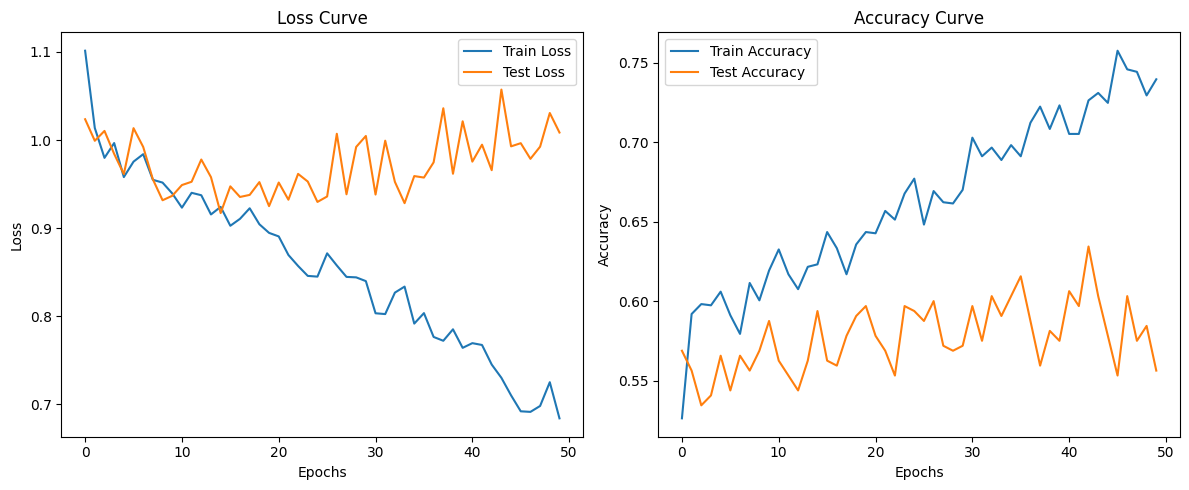

In [10]:
# Plot results
plot_results(results)

In [11]:
# --------------------------
# Prediction Function
# --------------------------
def predict(model, dataloader, device):
    model.eval()  # Evaluation mode
    predictions, confidences = [], []

    with torch.no_grad():
        for batch_features in dataloader:
            batch_features = batch_features.to(device)
            outputs = model(batch_features)
            probs = torch.softmax(outputs, dim=1)  # Confidence scores

            _, predicted_classes = torch.max(probs, 1)
            predictions.extend(predicted_classes.cpu().numpy())
            confidences.extend(probs.max(1).values.cpu().numpy())

    return predictions, confidences

In [23]:
# --------------------------
# Load and Preprocess Data for Prediction
# --------------------------
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# Example Data for Prediction (Pick 10 random samples)
new_data = data.sample(10).drop('quality', axis=1).values
print(new_data[0])


# Standardization (IMPORTANT: Use the same scaler from training)
scaler = StandardScaler()
new_data_scaled = scaler.fit_transform(new_data)

# DataLoader for Prediction
prediction_dataset = TabularDataset(new_data_scaled)
prediction_dataloader = DataLoader(prediction_dataset, batch_size=1, shuffle=False)

# --------------------------
# Load Trained Model
# --------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TabTransformer(num_features=new_data_scaled.shape[1], num_classes=6).to(device)


# --------------------------
# Perform Prediction
# --------------------------
predictions, confidences = predict(model, prediction_dataloader, device)

# --------------------------
# Display Results
# --------------------------
print("🔍 Prediction Results:")
labels = data['quality'].values - 3  # Zero-indexed labels
for idx, (pred, conf) in enumerate(zip(predictions, confidences)):
    print(f"Sample {idx + 1}: Predicted Quality Class ➔ {pred + 3} (Confidence: {conf:.2%})")
    print(f"labels {idx + 1}: Predicted Quality Class ➔ {labels[idx]}")


[ 5.4      0.58     0.08     1.9      0.059   20.      31.       0.99484
  3.5      0.64    10.2    ]
🔍 Prediction Results:
Sample 1: Predicted Quality Class ➔ 4 (Confidence: 30.18%)
labels 1: Predicted Quality Class ➔ 2
Sample 2: Predicted Quality Class ➔ 4 (Confidence: 27.45%)
labels 2: Predicted Quality Class ➔ 2
Sample 3: Predicted Quality Class ➔ 5 (Confidence: 39.99%)
labels 3: Predicted Quality Class ➔ 2
Sample 4: Predicted Quality Class ➔ 8 (Confidence: 21.86%)
labels 4: Predicted Quality Class ➔ 3
Sample 5: Predicted Quality Class ➔ 8 (Confidence: 27.24%)
labels 5: Predicted Quality Class ➔ 2
Sample 6: Predicted Quality Class ➔ 6 (Confidence: 36.70%)
labels 6: Predicted Quality Class ➔ 2
Sample 7: Predicted Quality Class ➔ 5 (Confidence: 56.13%)
labels 7: Predicted Quality Class ➔ 2
Sample 8: Predicted Quality Class ➔ 7 (Confidence: 34.18%)
labels 8: Predicted Quality Class ➔ 4
Sample 9: Predicted Quality Class ➔ 8 (Confidence: 26.96%)
labels 9: Predicted Quality Class ➔ 4
Sam